## Evaluation of TRIP pipeline results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from os import listdir
import numpy as np
from scipy import stats
from Bio.Seq import Seq
import seaborn as sn
import seaborn as sns
import itertools
from scipy.stats import gaussian_kde
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
import platform
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [2]:
import xgboost as xgb
#import shap


In [3]:
lsize=14
titlesize=16
axesthickness = 1.5
flierprops = dict(marker='o',markersize=1.5)
boxplot_kwargs = {'widths':0.65, 'vert':True, 'patch_artist':True, 'boxprops':dict(facecolor='#FEFBF3'), 'whis':[5, 95]}
bar_kwargs = {'color':'#C5DEFF', 'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}
plt.rcParams['axes.linewidth'] = axesthickness
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

### Create ML models for predicting editing based on chromatin characteristics

#### XGBoost

##### Import pre-prepared data for ML

In [8]:
path = '../../../../../PE_schwank/epridict/datasets_for_ml/chromatin/'
encode_df = pd.read_csv(path+'encode_df.csv', index_col='barcode')
# drop rows with NaNs in any column which is not in editingcollist
editingcollist = ['PE_edited_corrected_percentage', 'PE_unintended_editing_corrected_percentage', 'ABE8e_total_edited_corrected_percentage', 'BE4max_total_edited_corrected_percentage', 'Cas9_modified_corrected_percentage']
encode_df = encode_df.dropna(subset=[x for x in encode_df.columns if x not in editingcollist])

li_mapping_chromatindf = pd.read_csv(path+'li_mapping_chromatindf.csv', index_col='barcode')
li_mapping_chromatindf['insCTT_freq'] = li_mapping_chromatindf['insCTT_freq'].apply(lambda x: x*100)
li_mapping_chromatindf['D1_sg1'] = li_mapping_chromatindf['D1_sg1'].apply(lambda x: x*100)


li_features = ['DHS', 'H3K79me2', 'CTCF', 'POLR2A', 'ATAC', 'H3K9ac', 'H3K9me3',
       'H3K9me1', 'H4K20me1', 'BRD4', 'EZH2', 'H2AFZ', 'POLR2AS2', 'SMC3',
       'HDAC1', 'HDAC2', 'HDAC3', 'H3K4me3', 'H3K4me2', 'H3K4me1', 'H3K27me3',
       'H3K27ac', 'H3K36me3']


##### XGBoost function

In [5]:
def xgboosttrain(trainname, X, y, cv, best_params, performance_output=False):
    '''General function to train XGBoost model with cross validation'''
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
    kf = KFold(n_splits=cv, shuffle=True, random_state=0)
    print(trainname)
    xgboostspearmanscorelist = []
    xgboostpearsonscorelist = []
    xgboostmsescorelist = []

    all_preds = []
    all_y_test = []
        

    
    for train_idx, test_idx in kf.split(X, y):
        X_train = X[train_idx]
        X_test = X[test_idx]
        y_train = y[train_idx]
        y_test = y[test_idx]
        xg_reg.fit(X_train, y_train)
        preds = xg_reg.predict(X_test)
        print('Spearman correlation:',stats.spearmanr(preds, y_test)[0])
        xgboostspearmanscorelist.append(stats.spearmanr(preds, y_test)[0])
        xgboostpearsonscorelist.append(stats.pearsonr(preds, y_test)[0])
        xgboostmsescorelist.append(mean_squared_error(y_test, preds))


        all_preds.extend(preds)
        all_y_test.extend(y_test)
        # show scatter plot of predictions vs. true values
        # plt.scatter(preds, y_test)
        # plt.show()
    print('average spearman:', sum(xgboostspearmanscorelist) / len(xgboostspearmanscorelist))
    print('average pearson:', sum(xgboostpearsonscorelist) / len(xgboostpearsonscorelist))
    print('average mse:', sum(xgboostmsescorelist) / len(xgboostmsescorelist))

    # Train the model on the entire dataset after cross-validation
    xg_reg.fit(X, y)

    if performance_output == True:
        return xg_reg, all_preds, all_y_test, xgboostspearmanscorelist, xgboostpearsonscorelist, xgboostmsescorelist
    else:
        return xg_reg, all_preds, all_y_test

# print xgboost version
print(xgb.__version__)



os_version = platform.platform()
print("OS version:", os_version)

1.7.6
OS version: Windows-10-10.0.22621-SP0


In [6]:
def correlation_plot(x, y,xlabel,ylabel, title, trendline=False, max_x=100, max_y=100):
        x = np.array(x)
        y = np.array(y)
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        Correlation_x, Correlation_y, Correlation_z = x[idx], y[idx], z[idx]

        # Sort the points by density, so that the densest points are plotted last
        R = stats.spearmanr(x, y)[0]
        r = stats.pearsonr(x, y)[0]

        fig, ax = plt.subplots(figsize = (5, 5),dpi=150)
        ax.scatter(Correlation_x, Correlation_y, c=Correlation_z, s=0.3)
        xlabels=[0,20,40,60,80,100]
        ax.tick_params(axis='x', labelsize= 16, width=1.5)
        ax.tick_params(axis='y', labelsize= 16, width=1.5)
        ax.set_xlabel(xlabel, fontsize=16)
        ax.set_ylabel(ylabel, fontsize=16)
        ax.set_xlim(0, max_x)
        ax.set_ylim(0, max_y)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.text(0.05, 0.95, 'R = '+str(round(R, 2))+'\nr = '+str(round(r, 2)), transform=ax.transAxes, fontsize=16,
                verticalalignment='top')
        ax.set_title(title, fontsize=titlesize)
        if trendline == True:
                z = np.polyfit(x, y, 1)
                p = np.poly1d(z)
                # Set trendline color to gray, use '.' linestyle for dots, and set linewidth to a smaller value
                plt.plot(x, p(x), linestyle=':', color='gray', linewidth=1)
        
        plt.show()

##### Li et al. XGBoost models

4144
Spearman correlation: 0.53274534871676
Spearman p-value: 1.3197261273020685e-302
Pearson correlation: 0.5121540906334516
Pearson p-value: 5.760173143358286e-276


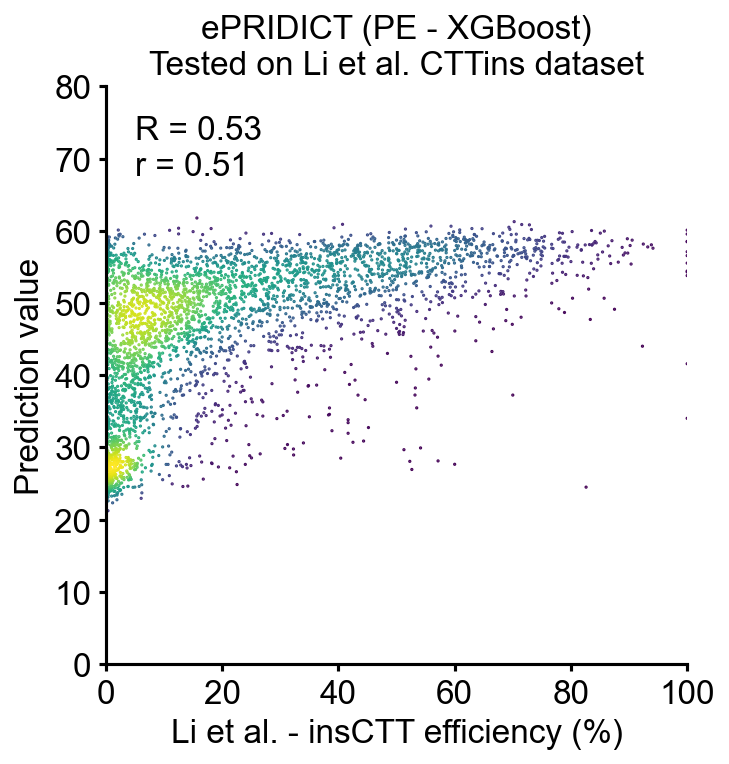

In [15]:
# predict performance of schwankmodel on li dataset with target 'insCTT_freq'
fulldf = li_mapping_chromatindf.copy()
target_column = 'insCTT_freq'
trainname = 'li_insCTT_encodeonly'
# drop all columns in the list li_features
fulldf = fulldf.drop(li_features, axis=1)

fulldf = fulldf.dropna(subset=[target_column])
editingcollist = ['seqnames', 'start', 'end', 'width', 'strand', 'pos', 'count', 'seq','ctt_total', 'insCTT_freq', 'D1_sg1', 'D2_sg1',
       'D4_sg1', 'txdb_overlap', 'distance', 'scaled_distance', 'gene', 'TPM']
# X is fulldf without editing columns
X = fulldf.drop(editingcollist, axis=1).values
print(len(X))
# y is target column
y = fulldf[target_column].values

xg_reg_pe_encodeprediction = xg_reg_pe_encode.predict(X)

# compare prediction with y
spearman_corr, spearman_pval = stats.spearmanr(xg_reg_pe_encodeprediction, y)
pearson_corr, pearson_pval = stats.pearsonr(xg_reg_pe_encodeprediction, y)

print('Spearman correlation:', spearman_corr)
print('Spearman p-value:', spearman_pval)
print('Pearson correlation:', pearson_corr)
print('Pearson p-value:', pearson_pval)
title = 'ePRIDICT (PE - XGBoost)\nTested on Li et al. CTTins dataset'
correlation_plot(y, xg_reg_pe_encodeprediction,'Li et al. - insCTT efficiency (%)','Prediction value', title, trendline=False, max_x=100, max_y=80)

##### Our dataset XGBoost models

encodeonly
Spearman correlation: 0.7137733981089008
Spearman correlation: 0.6422468579794072
Spearman correlation: 0.6675172435830133
Spearman correlation: 0.6768332694639874
Spearman correlation: 0.6676788379810743
average spearman: 0.6736099214232766
average pearson: 0.7463077627702981
average mse: 60.638382300192596


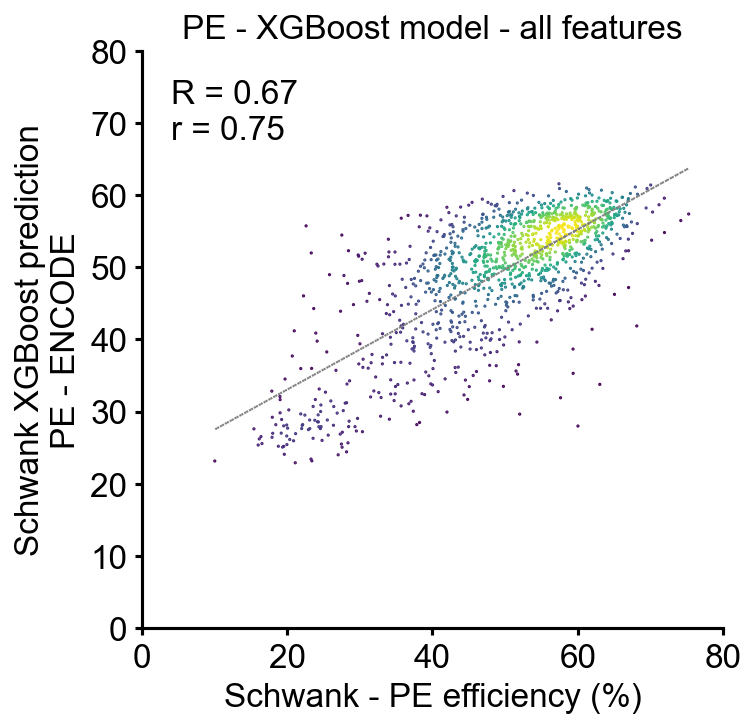

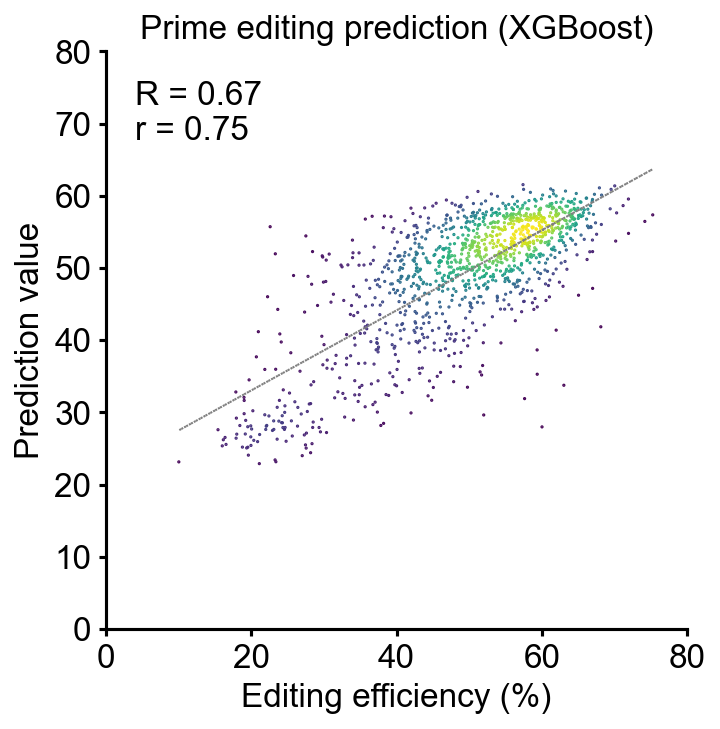

In [7]:
fulldf = encode_df.copy()
target_column = 'PE_edited_corrected_percentage'
trainname = 'encodeonly'

fulldf = fulldf.dropna(subset=[target_column])
editingcollist = ['PE_edited_corrected_percentage', 'PE_unintended_editing_corrected_percentage', 'ABE8e_total_edited_corrected_percentage', 'BE4max_total_edited_corrected_percentage', 'Cas9_modified_corrected_percentage']
# X is fulldf without editing columns
X = fulldf.drop(editingcollist, axis=1).values
featurecols = fulldf.drop(editingcollist, axis=1).columns
# save feature columns in txt file under ePRIDICT_full_model_column_names.txt
np.savetxt('ePRIDICT_full_model_column_names.txt', featurecols, fmt='%s')

# y is target column
y = fulldf[target_column].values
cv = 5
best_params = {'subsample': 0.4, 'n_estimators': 290, 'min_child_weight': 7, 'max_depth': 1, 'learning_rate': 0.05, 'gamma': 2.5, 'colsample_bytree': 0.7, 'alpha': 50, 'reg_lambda':1.5,'scale_pos_weight':2, 'seed': 0}


xg_reg_pe_encode, pe_encode_predictions, pe_encode_values, pe_encode_spearmanlist, pe_encode_pearsonlist, pe_encode_mselist = xgboosttrain(trainname, X, y, cv, best_params, performance_output=True)

xg_reg_pe_encode.save_model('epridict_full_xgboost_model.json')
xg_reg_pe_encode.save_model('./04_Paper/02_github/epridict/epridict_full_xgboost_model.json')

# store correlations
spearman_correlations = {}
pearson_correlations = {}
spearman_correlations['XGBoost'] = pe_encode_spearmanlist
pearson_correlations['XGBoost'] = pe_encode_pearsonlist


title = 'PE - XGBoost model - all features'
correlation_plot(pe_encode_values, pe_encode_predictions,'Schwank - PE efficiency (%)','Schwank XGBoost prediction\nPE - ENCODE', title, trendline=True, max_x=80, max_y=80)
title = 'Prime editing prediction (XGBoost)'
correlation_plot(pe_encode_values, pe_encode_predictions,'Editing efficiency (%)','Prediction value', title, trendline=True, max_x=80, max_y=80)

In [8]:

# Store the feature names for later use
feature_names = fulldf.drop(editingcollist, axis=1).columns

# Get feature importances
feature_importances = xg_reg_pe_encode.feature_importances_

# Create a DataFrame for easier manipulation
feature_importances_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})

# Sort by importance
feature_importances_df = feature_importances_df.sort_values(by="Importance", ascending=False)

print(feature_importances_df.head(20))
elements = ['HDAC2', 'H3K4me1', 'H3K4me2','H3K9me3', 'H3K27me3', 'Dnase']

top_features = {}

for element in elements:
    #print(element)
    # Filter the DataFrame
    element_df = feature_importances_df[feature_importances_df['Feature'].str.contains(element)]
    
    # Get the highest scoring feature
    top_feature = element_df.iloc[0]
    
    # Store in the dictionary
    top_features[element] = top_feature

    print(top_feature.Feature)

print(top_features)

                                     Feature  Importance
499      AFF1_ENCFF085LMT_average_value_5000    0.055855
962    NFATC3_ENCFF845HRN_average_value_2000    0.048097
1786  SMARCC2_ENCFF116RMR_average_value_2000    0.044586
1371     ZEB2_ENCFF793MZT_average_value_5000    0.042859
1307   ARID1B_ENCFF980AHZ_average_value_5000    0.031793
698      DPF2_ENCFF878GGX_average_value_2000    0.029550
122      HDGF_ENCFF171VPB_average_value_2000    0.029508
678       NBN_ENCFF101VAI_average_value_2000    0.029068
859   H3K4me1_ENCFF834SEY_average_value_5000    0.027637
1766     E4F1_ENCFF978GGB_average_value_2000    0.026848
270    H3K9ac_ENCFF286WRJ_average_value_2000    0.022450
647     ZNF24_ENCFF936KHI_average_value_5000    0.021693
123      HDGF_ENCFF171VPB_average_value_5000    0.021113
498      AFF1_ENCFF085LMT_average_value_2000    0.019340
677       NBN_ENCFF101VAI_average_value_1000    0.017188
697      DPF2_ENCFF878GGX_average_value_1000    0.016292
1305   ARID1B_ENCFF980AHZ_avera

##### Full PE schwank library without endogenous targets (top and bottom 10)

encodeonly without endo targets
Spearman correlation: 0.6688211275676128
Spearman correlation: 0.6345500759303151
Spearman correlation: 0.6675330123097675
Spearman correlation: 0.6324696466771351
Spearman correlation: 0.6644528329447671
average spearman: 0.6535653390859195
average pearson: 0.7276900060120107
average mse: 60.75231090480313


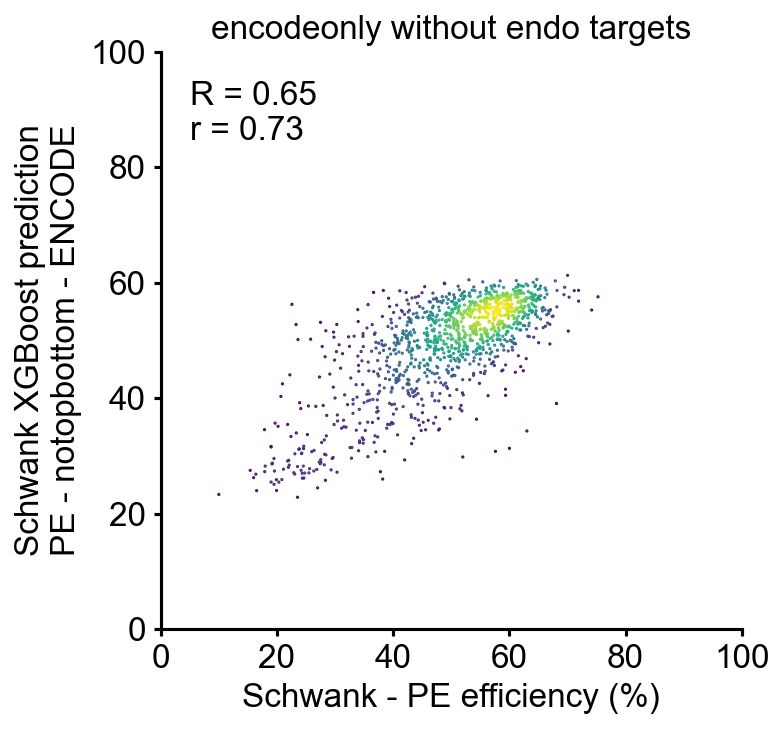

In [9]:

# get list of arrayed targets to filter out from predicting them
arrayedtargets = pd.read_excel('./02_Arrayed/cloning/top_bottom_locations/20230615_top_bottom_behive_batch_with_logit_scores_WITH_GENEANNNOTATION_only_selected_with_Shortname.xlsx')
arrayedtargets['chromosome'] = arrayedtargets['targetname'].apply(lambda x: x.split('_')[1])
arrayedtargets['position'] = arrayedtargets['targetname'].apply(lambda x: x.split('_')[2])
arrayedtargets['chromosome_position'] = arrayedtargets['chromosome'] + '_' + arrayedtargets['position']
chromposlist = arrayedtargets['chromosome_position'].tolist()


barcode_chromosome_overview = pd.read_csv('./01_TRIP_pool/02_Analysis/NM_TRIP_analysis/pool/results/mapping/20230416_alleditor_edited_mapped_summary.csv')
barcode_chromosome_overview['chromosome_position'] = barcode_chromosome_overview['chromosome'] + '_' + barcode_chromosome_overview['position'].astype(str)

# filter out rows of barcode_chromosome_overview where the chromosome_position is in the chromposlist
barcode_chromosome_overview = barcode_chromosome_overview[barcode_chromosome_overview['chromosome_position'].isin(chromposlist)]

endogenous_barcodes_to_filter_out = barcode_chromosome_overview['barcode'].tolist()


fulldf = encode_df.copy()
target_column = 'PE_edited_corrected_percentage'
trainname = 'encodeonly without endo targets'

fulldf = fulldf.dropna(subset=[target_column])

# filter out rows of fulldf where the index is in the endogenous_barcodes_to_filter_out list
fulldf = fulldf[~fulldf.index.isin(endogenous_barcodes_to_filter_out)]

editingcollist = ['PE_edited_corrected_percentage', 'PE_unintended_editing_corrected_percentage', 'ABE8e_total_edited_corrected_percentage', 'BE4max_total_edited_corrected_percentage', 'Cas9_modified_corrected_percentage']
# X is fulldf without editing columns
X = fulldf.drop(editingcollist, axis=1).values
# y is target column
y = fulldf[target_column].values
cv = 5
best_params = {'subsample': 0.4, 'n_estimators': 290, 'min_child_weight': 7, 'max_depth': 1, 'learning_rate': 0.05, 'gamma': 2.5, 'colsample_bytree': 0.7, 'alpha': 50, 'reg_lambda':1.5,'scale_pos_weight':2, 'seed': 0}


xg_reg_pe_encode_noendo, pe_encode_noendo_predictions, pe_encode_noendo_values = xgboosttrain(trainname, X, y, cv, best_params)

title = trainname
correlation_plot(pe_encode_noendo_values, pe_encode_noendo_predictions,'Schwank - PE efficiency (%)','Schwank XGBoost prediction\nPE - notopbottom - ENCODE', title)


# Save model to file
#pickle.dump(xg_reg_pe_encode_noendo, open("schwankmodel_encodefull_noendog_xgboost_model.pickle.pkl", "wb"))
xg_reg_pe_encode_noendo.save_model('schwankmodel_encodefull_noendog_xgboost_model.json')

#### Light model

1182
encode_minimal_version
Spearman correlation: 0.6672457012429657
Spearman correlation: 0.63846509227527
Spearman correlation: 0.6653553479072611
Spearman correlation: 0.6189775490807632
Spearman correlation: 0.6527391163434016
average spearman: 0.6485565613699322
average pearson: 0.7314182162139027
average mse: 66.81324987676221


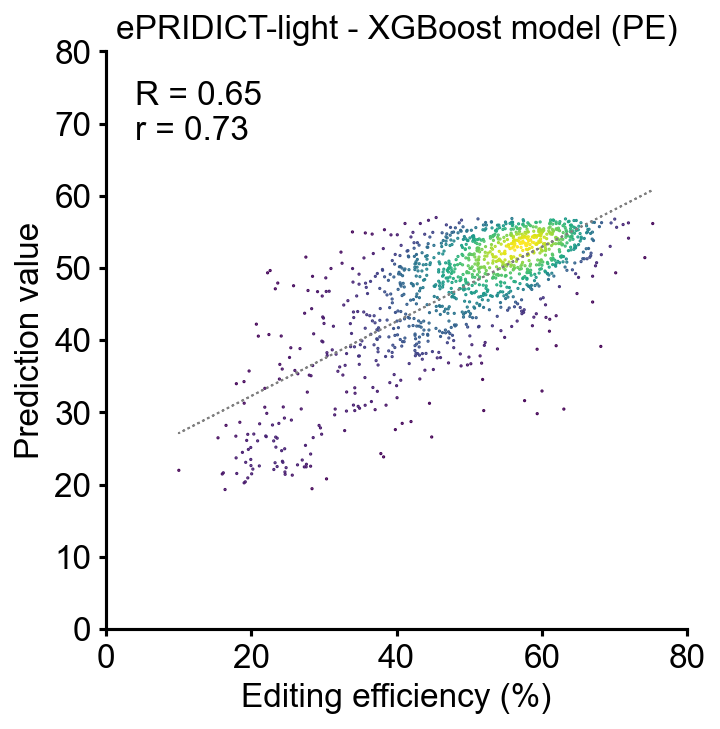

In [10]:

# contains only the top bigwig files for each chromatin feature (HDAC2, H3K4me1, H3K4me2, H3K9me3, H3K27me3, DNase-seq)
restricted_minimal_list = ['ENCFF954LGE','ENCFF834SEY','ENCFF959YJV','ENCFF601JGK','ENCFF139KZL', 'ENCFF972GVB']
fulldf = encode_df.copy()

target_column = 'PE_edited_corrected_percentage'
trainname = 'encode_minimal_version'

fulldf = fulldf.dropna(subset=[target_column])
editingcollist = ['PE_edited_corrected_percentage', 'PE_unintended_editing_corrected_percentage', 'ABE8e_total_edited_corrected_percentage', 'BE4max_total_edited_corrected_percentage', 'Cas9_modified_corrected_percentage']
# X is fulldf without editing columns
X = fulldf.drop(editingcollist, axis=1)
# keep only columns which have one of the entries in restricted_minimal_list as substring
X_temp = X[X.columns[X.columns.str.contains('|'.join(restricted_minimal_list))]]
featureslimcols = X_temp.columns
# save feature columns in txt file under ePRIDICT_full_model_column_names.txt
np.savetxt('ePRIDICT_slim_model_column_names.txt', featureslimcols, fmt='%s')

X = X_temp.values
print(len(X))
# y is target column
y = fulldf[target_column].values
cv = 5
best_params = {'subsample': 0.8, 'n_estimators': 110, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.03, 'gamma': 3, 'colsample_bytree': 0.8, 'alpha': 20,'reg_lambda':1.5,'scale_pos_weight':1, 'seed':0}


xg_reg_pe_encodeminimal, pe_encodeminimal_predictions ,pe_encodeminimal_values = xgboosttrain(trainname, X, y, cv, best_params)

title = 'ePRIDICT-light - XGBoost model (PE)'
correlation_plot(pe_encodeminimal_values, pe_encodeminimal_predictions,'Editing efficiency (%)','Prediction value', title, trendline=True, max_x=80, max_y=80)

# Save model to file
xg_reg_pe_encodeminimal.save_model('epridict_slim_xgboost_model.json')
xg_reg_pe_encodeminimal.save_model('./04_Paper/02_github/epridict/epridict_slim_xgboost_model.json')

### Other models

ABE8e_encode
Spearman correlation: 0.6754512525492347
Spearman correlation: 0.6825448559902035
Spearman correlation: 0.6760968679113845
Spearman correlation: 0.6940169379216042
Spearman correlation: 0.7006788781244901
average spearman: 0.6857577584993834
average pearson: 0.7537145369570024
average mse: 45.659779952543474


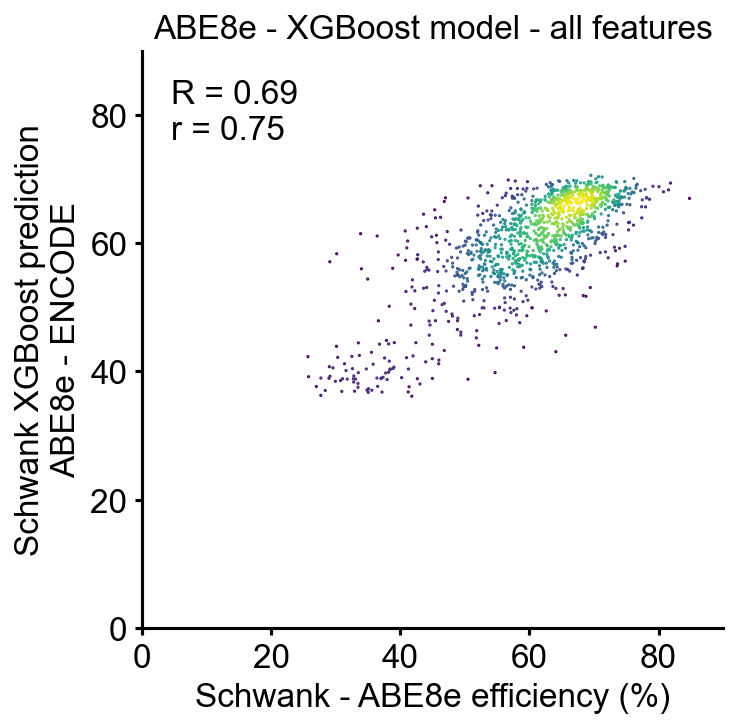

In [8]:
fulldf = encode_df.copy()
target_column = 'ABE8e_total_edited_corrected_percentage'
trainname = 'ABE8e_encode'

fulldf = fulldf.dropna(subset=[target_column])
editingcollist = ['PE_edited_corrected_percentage', 'PE_unintended_editing_corrected_percentage', 'ABE8e_total_edited_corrected_percentage', 'BE4max_total_edited_corrected_percentage', 'Cas9_modified_corrected_percentage']
# X is fulldf without editing columns
X = fulldf.drop(editingcollist, axis=1).values
# y is target column
y = fulldf[target_column].values
cv = 5
best_params = {'subsample': 0.4, 'n_estimators': 290, 'min_child_weight': 7, 'max_depth': 1, 'learning_rate': 0.05, 'gamma': 2.5, 'colsample_bytree': 0.7, 'alpha': 50, 'reg_lambda':1.5,'scale_pos_weight':2, 'seed': 0}

xg_reg_abe8e_encode, abe8e_encode_predictions, abe8e_encode_values, abe8e_encode_spearmanlist, abe8e_encode_pearsonlist, abe8e_encode_mselist = xgboosttrain(trainname, X, y, cv, best_params, performance_output=True)


title = 'ABE8e - XGBoost model - all features'
correlation_plot(abe8e_encode_values, abe8e_encode_predictions,'Schwank - ABE8e efficiency (%)','Schwank XGBoost prediction\nABE8e - ENCODE', title, max_x=90, max_y=90)


BE4max_encode
Spearman correlation: 0.6933077892188797
Spearman correlation: 0.6969600877606633
Spearman correlation: 0.6820268274673886
Spearman correlation: 0.7388804894342674
Spearman correlation: 0.696760649071874
average spearman: 0.7015871685906145
average pearson: 0.7531285178271968
average mse: 85.21502881739137


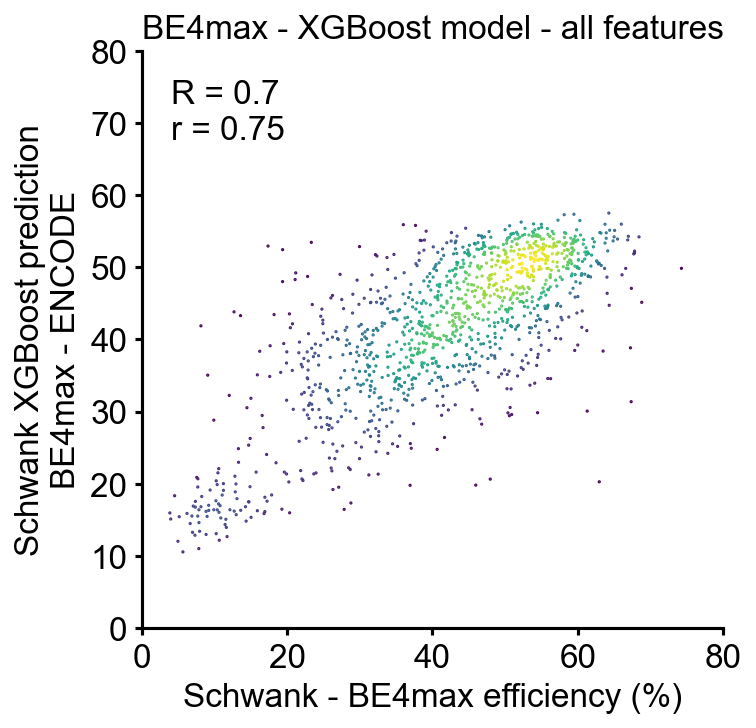

In [9]:
fulldf = encode_df.copy()
target_column = 'BE4max_total_edited_corrected_percentage'
trainname = 'BE4max_encode'

fulldf = fulldf.dropna(subset=[target_column])
editingcollist = ['PE_edited_corrected_percentage', 'PE_unintended_editing_corrected_percentage', 'ABE8e_total_edited_corrected_percentage', 'BE4max_total_edited_corrected_percentage', 'Cas9_modified_corrected_percentage']
# X is fulldf without editing columns
X = fulldf.drop(editingcollist, axis=1).values
# y is target column
y = fulldf[target_column].values
cv = 5
best_params = {'subsample': 0.4, 'n_estimators': 290, 'min_child_weight': 7, 'max_depth': 1, 'learning_rate': 0.05, 'gamma': 2.5, 'colsample_bytree': 0.7, 'alpha': 50, 'reg_lambda':1.5,'scale_pos_weight':2, 'seed': 0}


xg_reg_be4max_encode, be4max_encode_predictions, be4max_encode_values, be4max_encode_spearmanlist, be4max_encode_pearsonlist, be4max_encode_mselist = xgboosttrain(trainname, X, y, cv, best_params, performance_output=True)

title = 'BE4max - XGBoost model - all features'
correlation_plot(be4max_encode_values, be4max_encode_predictions,'Schwank - BE4max efficiency (%)','Schwank XGBoost prediction\nBE4max - ENCODE', title, max_x=80, max_y=80)


Cas9_encode


Spearman correlation: 0.3286228927585548
Spearman correlation: 0.36852782954185853
Spearman correlation: 0.3635517386871066
Spearman correlation: 0.4041085053268169
Spearman correlation: 0.22997872789283072
average spearman: 0.33895793884143355
average pearson: 0.3587505446323345
average mse: 92.81104536509253


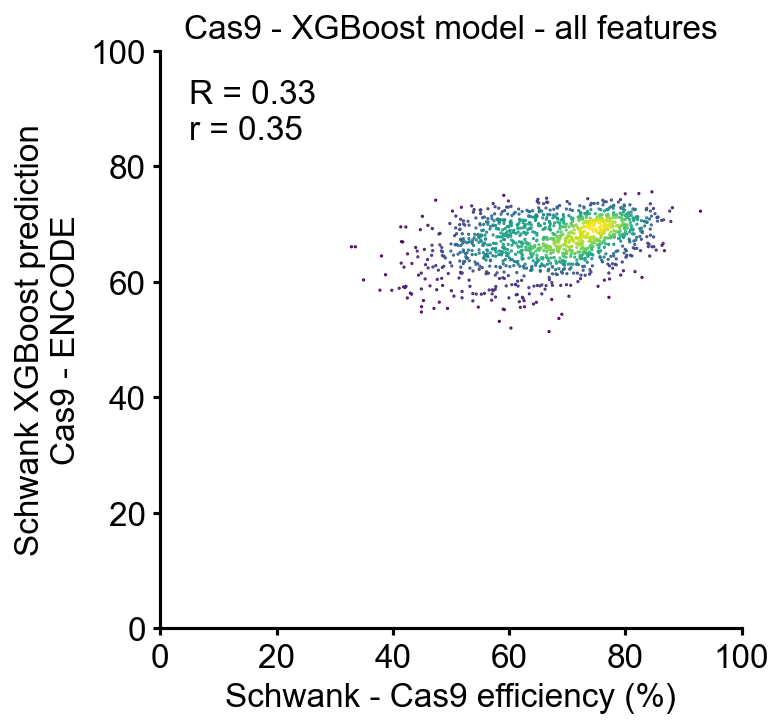

In [10]:
fulldf = encode_df.copy()
target_column = 'Cas9_modified_corrected_percentage'
trainname = 'Cas9_encode'

fulldf = fulldf.dropna(subset=[target_column])
editingcollist = ['PE_edited_corrected_percentage', 'PE_unintended_editing_corrected_percentage', 'ABE8e_total_edited_corrected_percentage', 'BE4max_total_edited_corrected_percentage', 'Cas9_modified_corrected_percentage']
# X is fulldf without editing columns
X = fulldf.drop(editingcollist, axis=1).values
# y is target column
y = fulldf[target_column].values
cv = 5
best_params = {'subsample': 0.4, 'n_estimators': 290, 'min_child_weight': 7, 'max_depth': 1, 'learning_rate': 0.05, 'gamma': 2.5, 'colsample_bytree': 0.7, 'alpha': 50, 'reg_lambda':1.5,'scale_pos_weight':2, 'seed': 0}


xg_reg_cas9_encode, cas9_encode_predictions, cas9_encode_values, cas9_encode_spearmanlist, cas9_encode_pearsonlist, cas9_encode_mselist = xgboosttrain(trainname, X, y, cv, best_params, performance_output=True)

title = 'Cas9 - XGBoost model - all features'
correlation_plot(cas9_encode_values, cas9_encode_predictions,'Schwank - Cas9 efficiency (%)','Schwank XGBoost prediction\nCas9 - ENCODE', title)


#### Create barplots to compare PE ML models

In [10]:
# from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet

def train_model(model, trainname, X, y, cv):
    '''General function to train a model with cross validation'''
    print(trainname)
    spearmanscorelist = []
    pearsonscorelist = []

    all_preds = []
    all_y_test = []

    kf = KFold(n_splits=cv, shuffle=True, random_state=0)
    for train_idx, test_idx in kf.split(X, y):
        X_train = X[train_idx]
        X_test = X[test_idx]
        y_train = y[train_idx]
        y_test = y[test_idx]
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        print('Spearman correlation:',stats.spearmanr(preds, y_test)[0])
        print('Pearson correlation:',stats.pearsonr(preds, y_test)[0])

        spearmanscorelist.append(stats.spearmanr(preds, y_test)[0])
        pearsonscorelist.append(stats.pearsonr(preds, y_test)[0])

        all_preds.extend(preds)
        all_y_test.extend(y_test)

    print('average spearman:', np.mean(spearmanscorelist))
    print('average pearson:', np.mean(pearsonscorelist))

    # Train the model on the entire dataset after cross-validation
    # model.fit(X, y)

    return model, all_preds, all_y_test, spearmanscorelist, pearsonscorelist

# define models
models = {
    'RandomForest': RandomForestRegressor(random_state=0),
    'Ridge': Ridge(random_state=0),
    'Lasso': Lasso(random_state=0),
    'ElasticNet': ElasticNet(random_state=0),
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state=0)
    
}

fulldf = encode_df.copy()
target_column = 'PE_edited_corrected_percentage'
trainname = 'encodeonly'

fulldf = fulldf.dropna(subset=[target_column])
editingcollist = ['PE_edited_corrected_percentage', 'PE_unintended_editing_corrected_percentage', 'ABE8e_total_edited_corrected_percentage', 'BE4max_total_edited_corrected_percentage', 'Cas9_modified_corrected_percentage']
# X is fulldf without editing columns
X = fulldf.drop(editingcollist, axis=1).values
# y is target column
y = fulldf[target_column].values

cv = 5 
# iterate over models
for model_name, model in models.items():
    _, _, _, spearman_corr, pearson_corr = train_model(model, model_name, X, y, cv)
    spearman_correlations[model_name] = spearman_corr
    pearson_correlations[model_name] = pearson_corr


RandomForest
Spearman correlation: 0.6882955762675026
Pearson correlation: 0.7214251212543106
Spearman correlation: 0.6398534955711528
Pearson correlation: 0.7592194250272518
Spearman correlation: 0.6424454618906544
Pearson correlation: 0.7358424321841976
Spearman correlation: 0.6605241000525354
Pearson correlation: 0.7377676984965892
Spearman correlation: 0.679802069686443
Pearson correlation: 0.7714703314851803
average spearman: 0.6621841406936576
average pearson: 0.7451450016895059
Ridge
Spearman correlation: 0.3131154261256604
Pearson correlation: 0.32110817534336816
Spearman correlation: 0.3719393356999525
Pearson correlation: 0.3794843625101616
Spearman correlation: 0.4862859307882976
Pearson correlation: 0.5071767135949201
Spearman correlation: 0.4167538736445747
Pearson correlation: 0.2942979715248659
Spearman correlation: 0.5139496135885367
Pearson correlation: 0.5009507930826977
average spearman: 0.42040883596940437
average pearson: 0.4006036032112027
Lasso
Spearman correlati

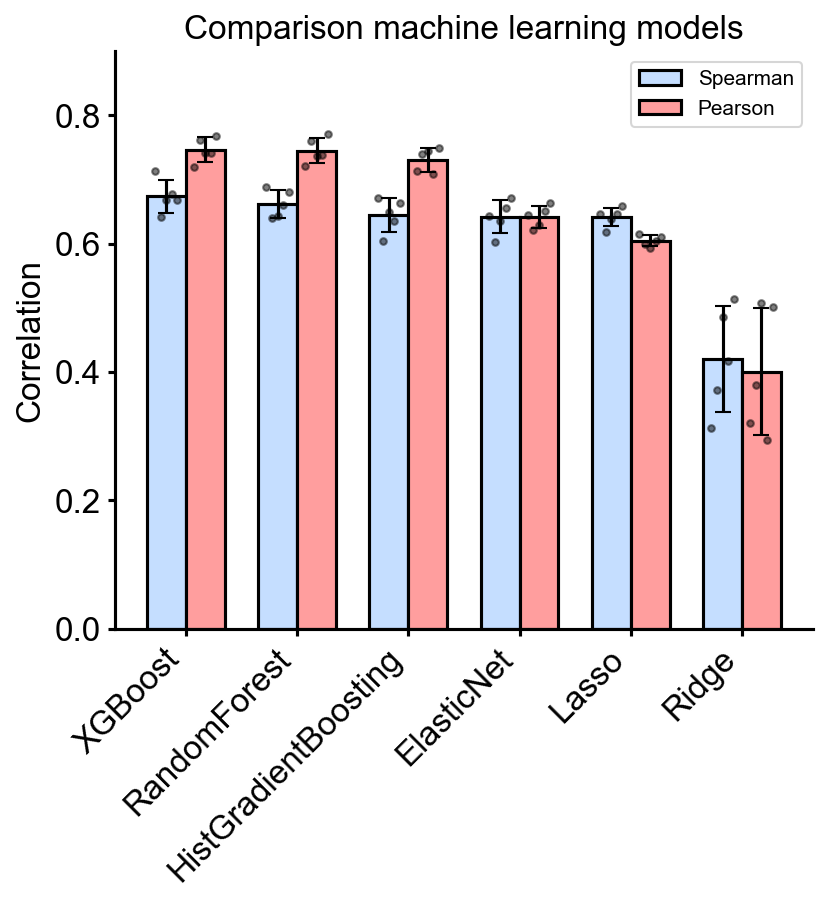

In [14]:

# Convert dictionaries to DataFrame
spearman_df = pd.DataFrame.from_dict(spearman_correlations, orient='index').transpose()
pearson_df = pd.DataFrame.from_dict(pearson_correlations, orient='index').transpose()

# Define the order
order = ['XGBoost', 'RandomForest', 'HistGradientBoosting', 'ElasticNet', 'Lasso', 'Ridge']

# Reorder the columns in both dataframes according to the defined order
spearman_df = spearman_df[order]
pearson_df = pearson_df[order]

# Calculate mean and std for error bars
spearman_mean = spearman_df.mean()
spearman_std = spearman_df.std()

pearson_mean = pearson_df.mean()
pearson_std = pearson_df.std()

# Define the colors for the Spearman and Pearson correlations
bar_kwargs_spearman = {'color':'#C5DEFF', 'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}
bar_kwargs_pearson = {'color':'#ff9e9e', 'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}

# Prepare figure
fig, ax = plt.subplots(figsize=(6,5), dpi=150, sharex=True)

# Create an array for the position of each bar on the x-axis
x = np.arange(len(order))

# Set the bar width
bar_width = 0.35

# Bar plot with error bars
ax.bar(x - bar_width/2, spearman_mean, yerr=spearman_std, width=bar_width, **bar_kwargs_spearman, label='Spearman')
ax.bar(x + bar_width/2, pearson_mean, yerr=pearson_std, width=bar_width, **bar_kwargs_pearson, label='Pearson')

# Scatter individual data points
for i, label in enumerate(spearman_mean.index):
    y_spearman = spearman_df.loc[:, label]
    y_pearson = pearson_df.loc[:, label]
    
    for runnr in range(5):
        ax.scatter(i-bar_width/2+(runnr/10-0.2)/2, y_spearman[runnr], s=10, color='black',alpha=0.5,zorder=2)
        ax.scatter(i+bar_width/2+(runnr/10-0.2)/2, y_pearson[runnr], s=10, color='black',alpha=0.5,zorder=2)

# Set settings for plot
ax.set_xticks(x)
ax.set_xticklabels(spearman_mean.index, ha="right")
ax.set_ylabel('Correlation', fontsize=16)
ax.tick_params(axis='x', labelsize=16, width=1.5, rotation=45)
ax.tick_params(axis='y', labelsize=16, width=1.5)
ax.set_ylim(0, 0.9)
ax.set_title('Comparison machine learning models', size=16)

# ax.set_title('ePRIDICT - PE editing\nComparison machine learning models')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add a legend
ax.legend()

plt.show()

#### Create barplots to compare PE/ABE8e/BE4max/Cas9 XGBoost models

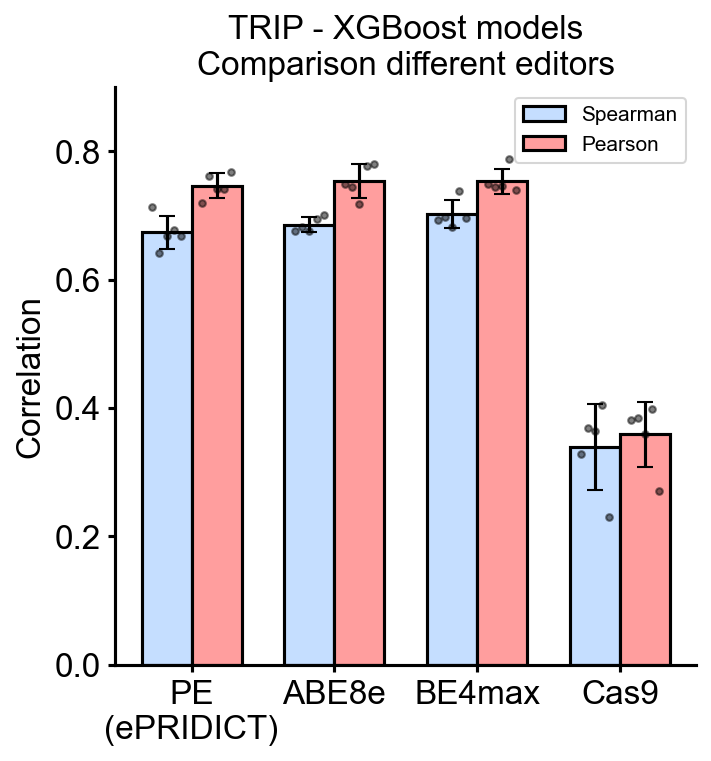

In [16]:
editor_comparison_spearman_correlations = {}
editor_comparison_pearson_correlations = {}
editor_comparison_spearman_correlations['PE\n(ePRIDICT)'] = pe_encode_spearmanlist
editor_comparison_pearson_correlations['PE\n(ePRIDICT)'] = pe_encode_pearsonlist
editor_comparison_spearman_correlations['ABE8e'] = abe8e_encode_spearmanlist
editor_comparison_pearson_correlations['ABE8e'] = abe8e_encode_pearsonlist
editor_comparison_spearman_correlations['BE4max'] = be4max_encode_spearmanlist
editor_comparison_pearson_correlations['BE4max'] = be4max_encode_pearsonlist
editor_comparison_spearman_correlations['Cas9'] = cas9_encode_spearmanlist
editor_comparison_pearson_correlations['Cas9'] = cas9_encode_pearsonlist


# Convert dictionaries to DataFrame
spearman_df = pd.DataFrame.from_dict(editor_comparison_spearman_correlations, orient='index').transpose()
pearson_df = pd.DataFrame.from_dict(editor_comparison_pearson_correlations, orient='index').transpose()

# Define the order
order = ['PE\n(ePRIDICT)', 'ABE8e', 'BE4max', 'Cas9']

# Reorder the columns in both dataframes according to the defined order
spearman_df = spearman_df[order]
pearson_df = pearson_df[order]

# Calculate mean and std for error bars
spearman_mean = spearman_df.mean()
spearman_std = spearman_df.std()

pearson_mean = pearson_df.mean()
pearson_std = pearson_df.std()

# Define the colors for the Spearman and Pearson correlations
bar_kwargs_spearman = {'color':'#C5DEFF', 'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}
bar_kwargs_pearson = {'color':'#ff9e9e', 'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}

# Prepare figure
fig, ax = plt.subplots(figsize=(5,5), dpi=150, sharex=True)

# Create an array for the position of each bar on the x-axis
x = np.arange(len(order))

# Set the bar width
bar_width = 0.35

# Bar plot with error bars
ax.bar(x - bar_width/2, spearman_mean, yerr=spearman_std, width=bar_width, **bar_kwargs_spearman, label='Spearman')
ax.bar(x + bar_width/2, pearson_mean, yerr=pearson_std, width=bar_width, **bar_kwargs_pearson, label='Pearson')

# Scatter individual data points
for i, label in enumerate(spearman_mean.index):
    y_spearman = spearman_df.loc[:, label]
    y_pearson = pearson_df.loc[:, label]
    
    for runnr in range(5):
        ax.scatter(i-bar_width/2+(runnr/10-0.2)/2, y_spearman[runnr], s=10, color='black',alpha=0.5,zorder=2)
        ax.scatter(i+bar_width/2+(runnr/10-0.2)/2, y_pearson[runnr], s=10, color='black',alpha=0.5,zorder=2)

# Set settings for plot
ax.set_xticks(x)
ax.set_xticklabels(spearman_mean.index, ha="center")
ax.set_ylabel('Correlation', fontsize=16)
ax.tick_params(axis='x', labelsize=16, width=1.5, rotation=0)
ax.tick_params(axis='y', labelsize=16, width=1.5)
ax.set_ylim(0, 0.9)
ax.set_title('TRIP - XGBoost models\nComparison different editors', size=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add a legend
ax.legend()

plt.show()

##### RandomGridSearchCV
###### Used to find the best parameters for the XGBoost model - stored in separate python files for each model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer
from scipy import stats
import numpy as np
import pandas as pd
import xgboost as xgb

# Load your data

path = './datasets/'
# path= './04_Paper/02_github/epridict/datasets_for_ml/chromatin/'
encode_df = pd.read_csv(path+'encode_df.csv', index_col='barcode')
# drop rows with NaNs in any column which is not in editingcollist
editingcollist = ['PE_edited_corrected_percentage', 'PE_unintended_editing_corrected_percentage', 'ABE8e_total_edited_corrected_percentage', 'BE4max_total_edited_corrected_percentage', 'Cas9_modified_corrected_percentage']
encode_df = encode_df.dropna(subset=[x for x in encode_df.columns if x not in editingcollist])
fulldf = encode_df.copy()
target_column = 'PE_edited_corrected_percentage'
trainname = 'encodeonly'

fulldf = fulldf.dropna(subset=[target_column])
editingcollist = ['PE_edited_corrected_percentage', 'PE_unintended_editing_corrected_percentage', 'ABE8e_total_edited_corrected_percentage', 'BE4max_total_edited_corrected_percentage', 'Cas9_modified_corrected_percentage']
# X is fulldf without editing columns
X = fulldf.drop(editingcollist, axis=1).values
# y is target column
y = fulldf[target_column].values


cv = 5

# Define the parameter space
param_dist = {
    'subsample': [0.2, 0.4, 0.6, 0.8, 1.0],
    'n_estimators': [50, 80, 110, 140, 170, 200, 230, 260, 290],
    'min_child_weight': [1, 4, 7, 10, 13, 16, 19, 22, 25],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'gamma': [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0],
    'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'alpha': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'reg_lambda': [0.5, 1, 1.5, 2, 2.5],
    'scale_pos_weight': [0.5, 1, 1.5, 2, 2.5],
    'seed': [0]
}

# Create a XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror')

# Define custom scoring functions
def spearman_corr(y_true, y_pred):
    return stats.spearmanr(y_true, y_pred)[0]

def pearson_corr(y_true, y_pred):
    return stats.pearsonr(y_true, y_pred)[0]

scoring = {'spearman_corr': make_scorer(spearman_corr), 'pearson_corr': make_scorer(pearson_corr)}

# Set up the randomized search with joblib parallelization
random_search = RandomizedSearchCV(
    xg_reg,
    param_distributions=param_dist,
    n_iter=1000,
    cv=KFold(n_splits=cv, shuffle=True, random_state=0),
    random_state=0,
    scoring=scoring,
    refit=False,  # do not refit an estimator to the whole dataset
    n_jobs=-1  # use all available cores
)

# Run the randomized search
random_search.fit(X, y)

# Extract the results
cv_results = random_search.cv_results_

# Calculate the average Spearman and Pearson correlations
spearman_avg = cv_results['mean_test_spearman_corr']
pearson_avg = cv_results['mean_test_pearson_corr']

# Extract the Spearman and Pearson correlations for each split
spearman_splits = [cv_results[f'split{i}_test_spearman_corr'] for i in range(cv)]
pearson_splits = [cv_results[f'split{i}_test_pearson_corr'] for i in range(cv)]

# Create a DataFrame to hold the results
results_df = pd.DataFrame({
    **{param: cv_results[f'param_{param}'] for param in param_dist.keys()},
    **{f'spearman{i+1}': spearman_splits[i] for i in range(cv)},
    **{f'pearman{i+1}': pearson_splits[i] for i in range(cv)},
    'spearman_average': spearman_avg,
    'pearson_average': pearson_avg
})

# Save the results to a CSV file
results_df.to_csv('20230730_XGBoost_PE_ePRIDICT_random_search_results.csv', index=False)
